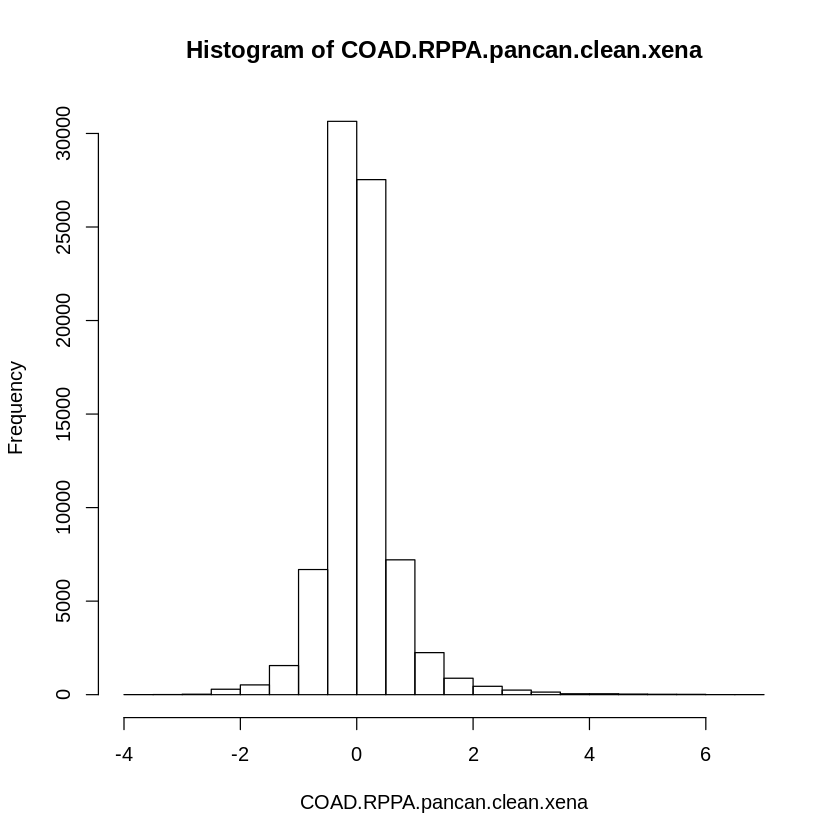

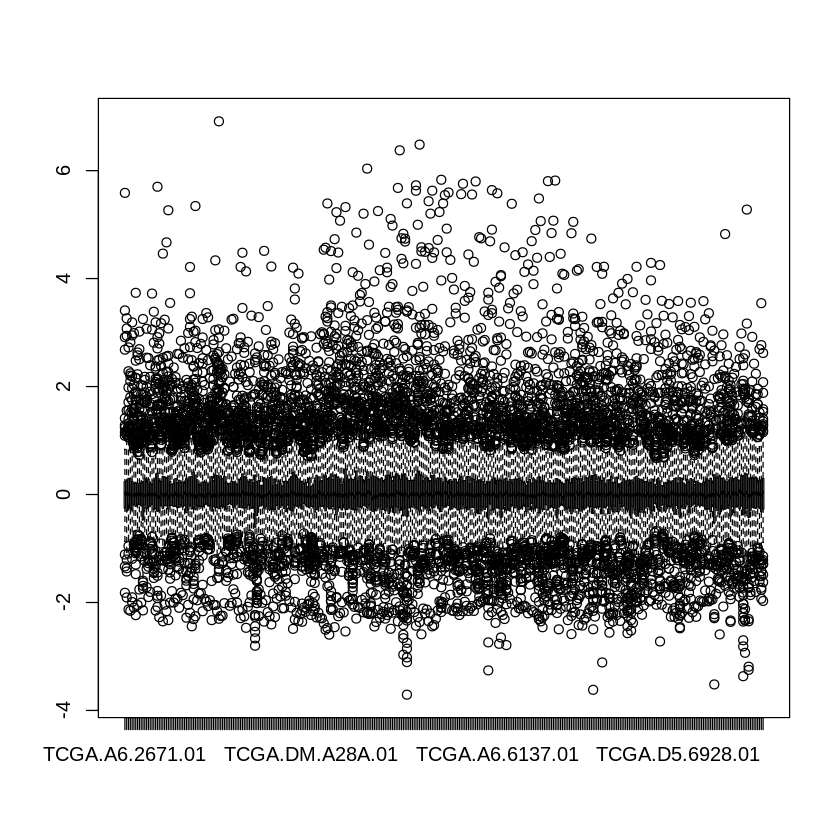

In [2]:
#### 4.RPPA_data_analysis.R
### https://xenabrowser.net/datapages/?dataset=TCGA-RPPA-pancan-clean.xena&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443
### 1) Loaging Protein data RPPA
COAD_TCGA_RPPA_clean_xena_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_Pan_Cancer/RPPA_n_7744/COAD_TCGA_RPPA_clean_xena_dataset.rds")
COAD.RPPA.pancan.clean.xena <- COAD_TCGA_RPPA_clean_xena_dataset$COAD.RPPA.pancan.clean.xena
COAD.RPPA.pancan.clean.xena <- as.matrix(COAD.RPPA.pancan.clean.xena)
hist(COAD.RPPA.pancan.clean.xena)
boxplot(COAD.RPPA.pancan.clean.xena)
### 2)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res


In [3]:
### 3)Builed ExpressionSet
library(Biobase)
table(Cluster.df$rownames %in% colnames(COAD.RPPA.pancan.clean.xena))
sampleID <- Cluster.df$rownames[Cluster.df$rownames %in% colnames(COAD.RPPA.pancan.clean.xena)]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df[sampleID,])
COAD.RPPA.set <- ExpressionSet(assayData=COAD.RPPA.pancan.clean.xena[,sampleID],
                                phenoData=Cluster.df.sub)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory mat


FALSE  TRUE 
   52   234 


Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA



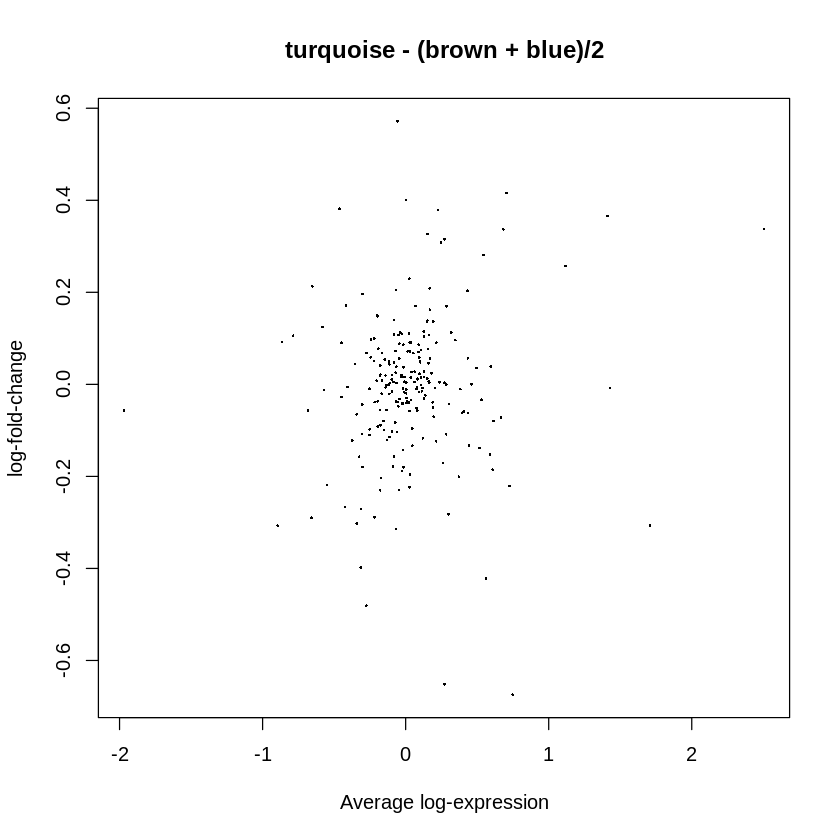

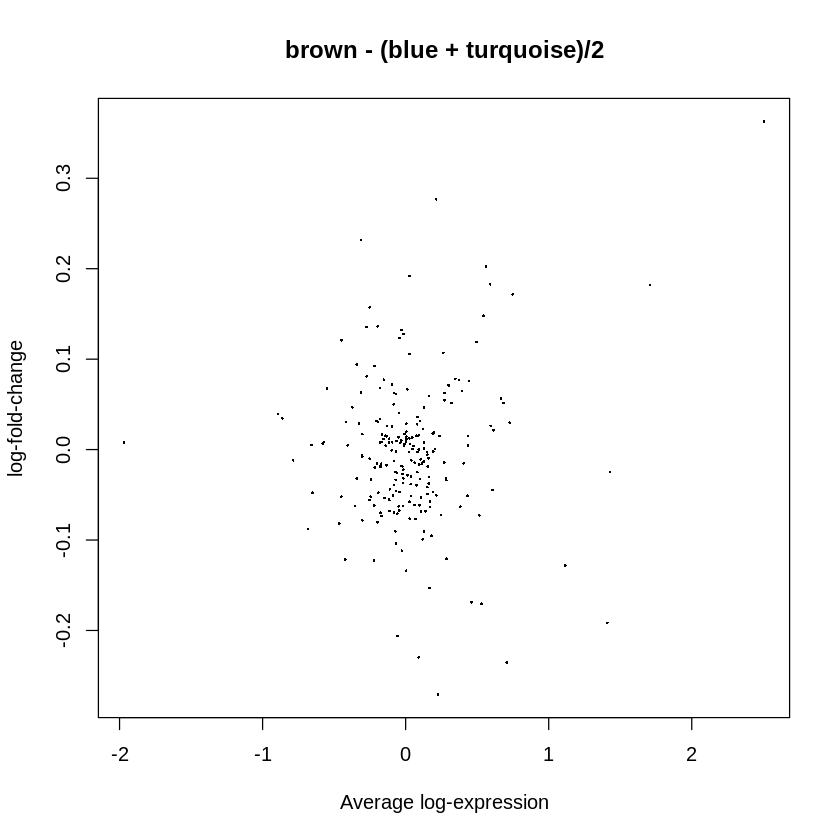

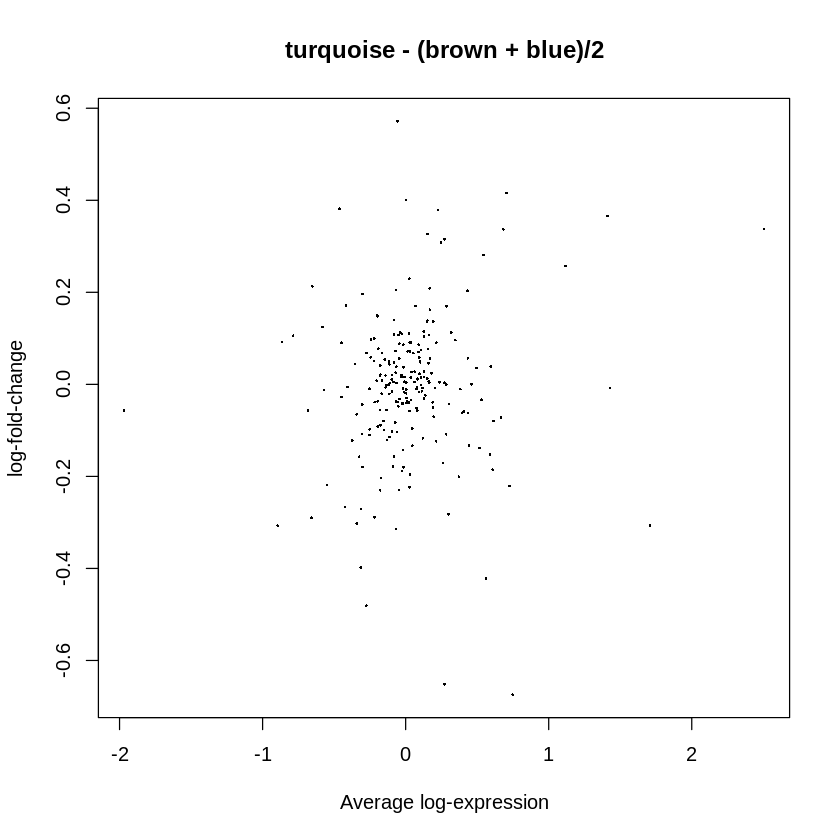

In [4]:
## 4) differential RPPA analysis limma version
## Several Groups experiment design
library(limma)
#Cluster.df.sub@data$dynamicColors
f.RPPA <- factor(Cluster.df.sub@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.RPPA <- model.matrix(~0+f.RPPA)
colnames(design.RPPA) <- c("blue","brown","turquoise","yellow")
# fit the linear model 
fit.RPPA <- lmFit(COAD.RPPA.set, design.RPPA)
contrast.matrix.RPPA <- makeContrasts(blue-(brown+turquoise)/2, 
                                       brown-(blue+turquoise)/2,
                                       turquoise-(brown+blue)/2,
                                       levels=design.RPPA)
# fit the contrasts
fit.RPPA.2 <- contrasts.fit(fit.RPPA, contrast.matrix.RPPA)
fit.RPPA.2 <- eBayes(fit.RPPA.2)
# Check out ploting
plotMD(fit.RPPA.2)
plotMD(fit.RPPA.2, column = 2)
plotMD(fit.RPPA.2, column = 3)

In [5]:
### 5) Set up cutoff for top DE RPPA
#adjPvalueCutoff <- 0.01
#logFCcutoff <- 0.5
summary(decideTests(fit.RPPA.2))
number = 10
RPPA.blue <- topTable(fit.RPPA.2, num=number, coef="blue - (brown + turquoise)/2")
RPPA.brown <- topTable(fit.RPPA.2, num=number, coef="brown - (blue + turquoise)/2")
RPPA.turquoise <- topTable(fit.RPPA.2, num=number, coef="turquoise - (brown + blue)/2")
head(RPPA.blue)
# look at the numbers of DM CpGs at FDR < 0.05
summary(decideTests(fit.RPPA.2))

       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                             22                            0
NotSig                          174                          223
Up                               27                            0
       turquoise - (brown + blue)/2
Down                             31
NotSig                          157
Up                               35

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S6,0.3453091,-0.27479862,5.363764,1.964574e-07,4.380999e-05,6.659010
SRC_pY416,-0.3883135,0.68271088,-4.977540,1.253510e-06,1.397663e-04,4.885746
FOXM1,0.3000073,-0.02638362,4.733403,3.835642e-06,2.851160e-04,3.819927
TSC1,0.2111860,0.29983226,4.344543,2.085358e-05,1.162587e-03,2.214197
MEK1,-0.1642128,0.31891962,-4.165788,4.375058e-05,1.728877e-03,1.515153
ANNEXIN1,-0.2997504,-0.46305278,-4.138020,4.898211e-05,1.728877e-03,1.408824


       blue - (brown + turquoise)/2 brown - (blue + turquoise)/2
Down                             22                            0
NotSig                          174                          223
Up                               27                            0
       turquoise - (brown + blue)/2
Down                             31
NotSig                          157
Up                               35

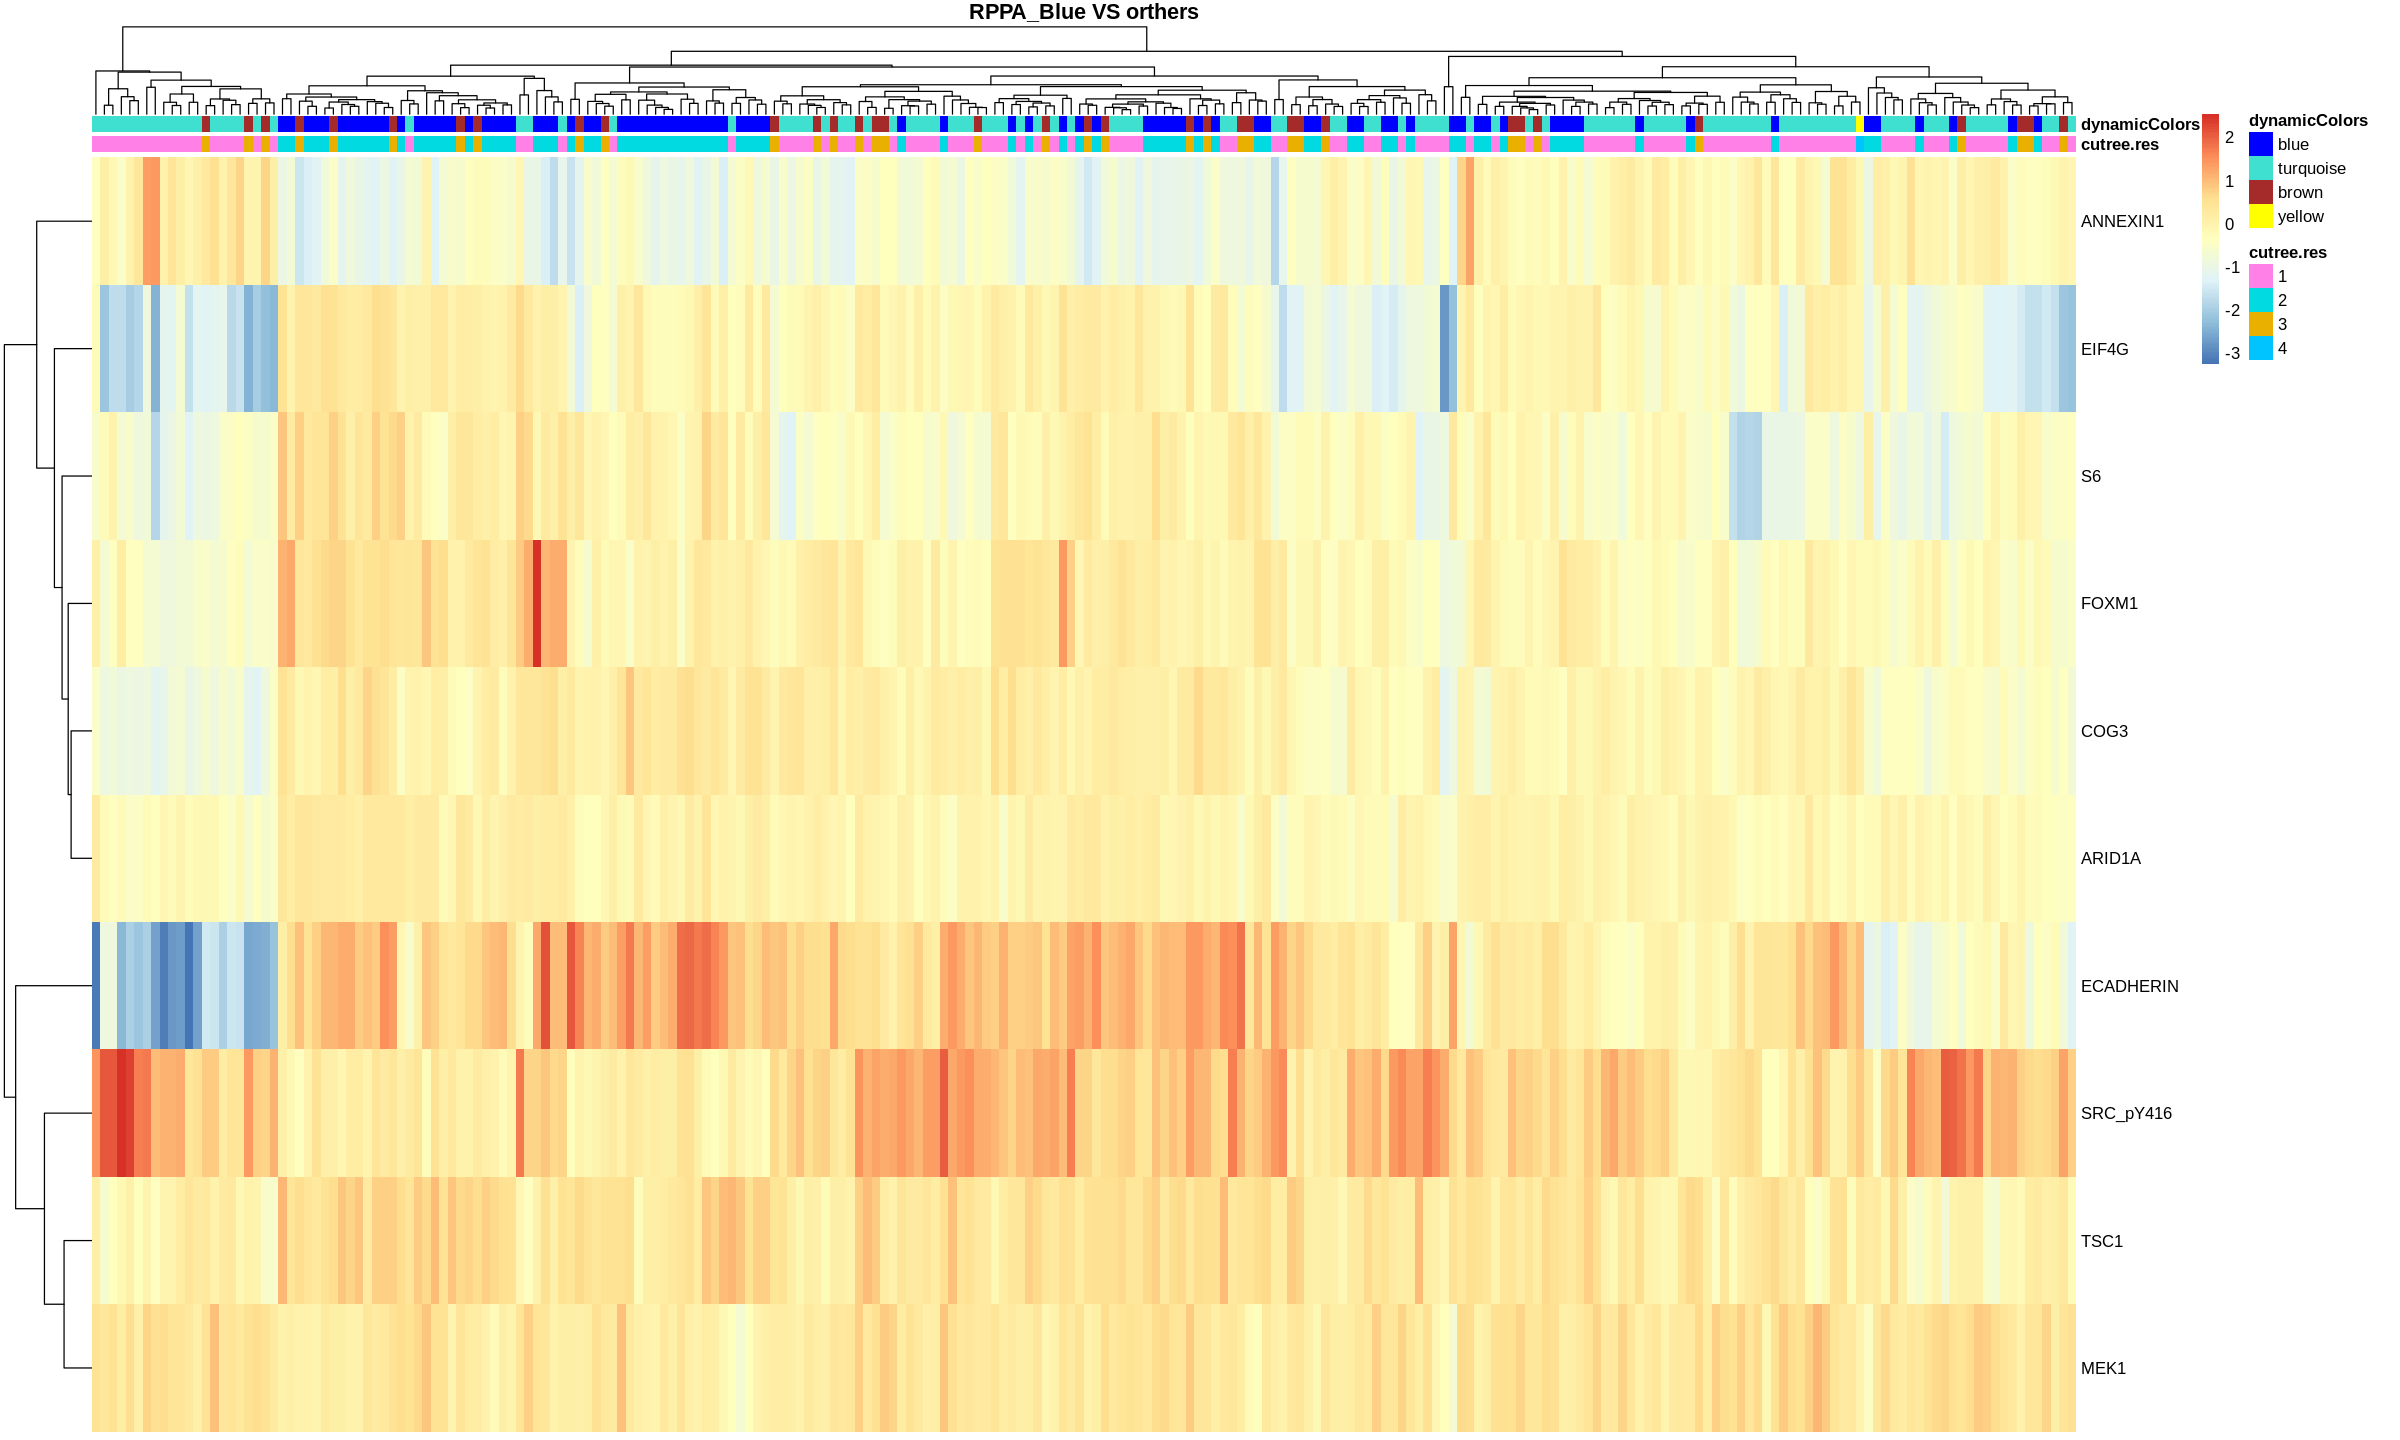

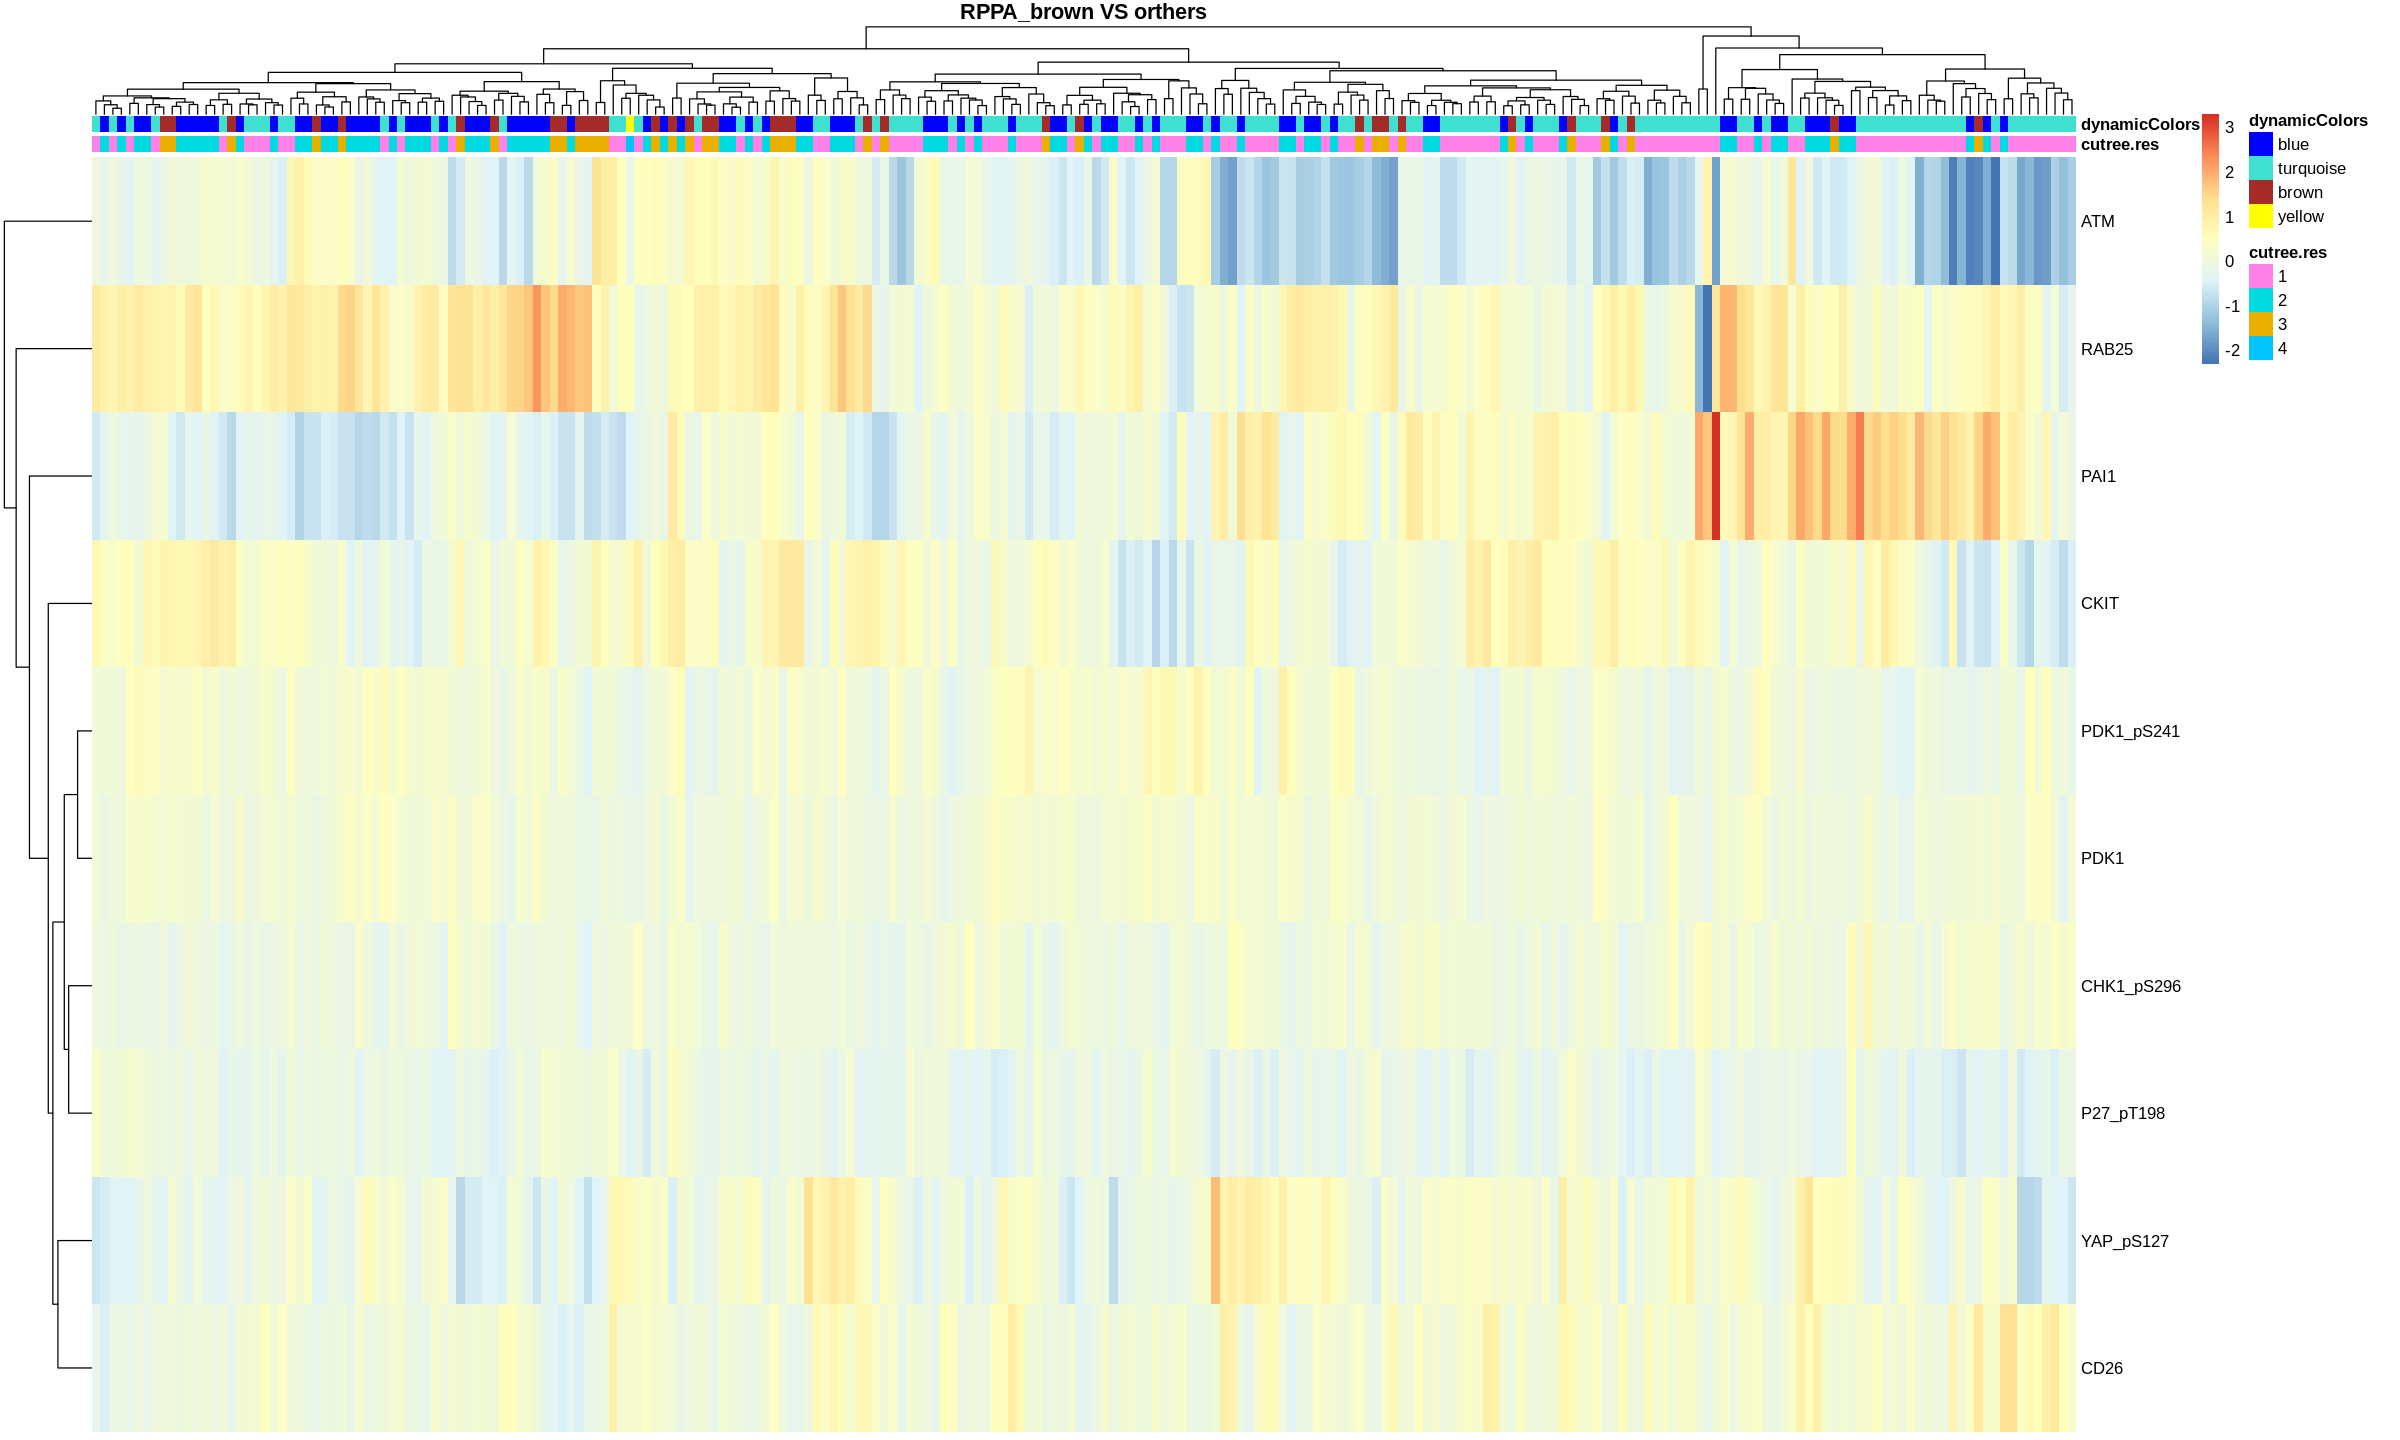

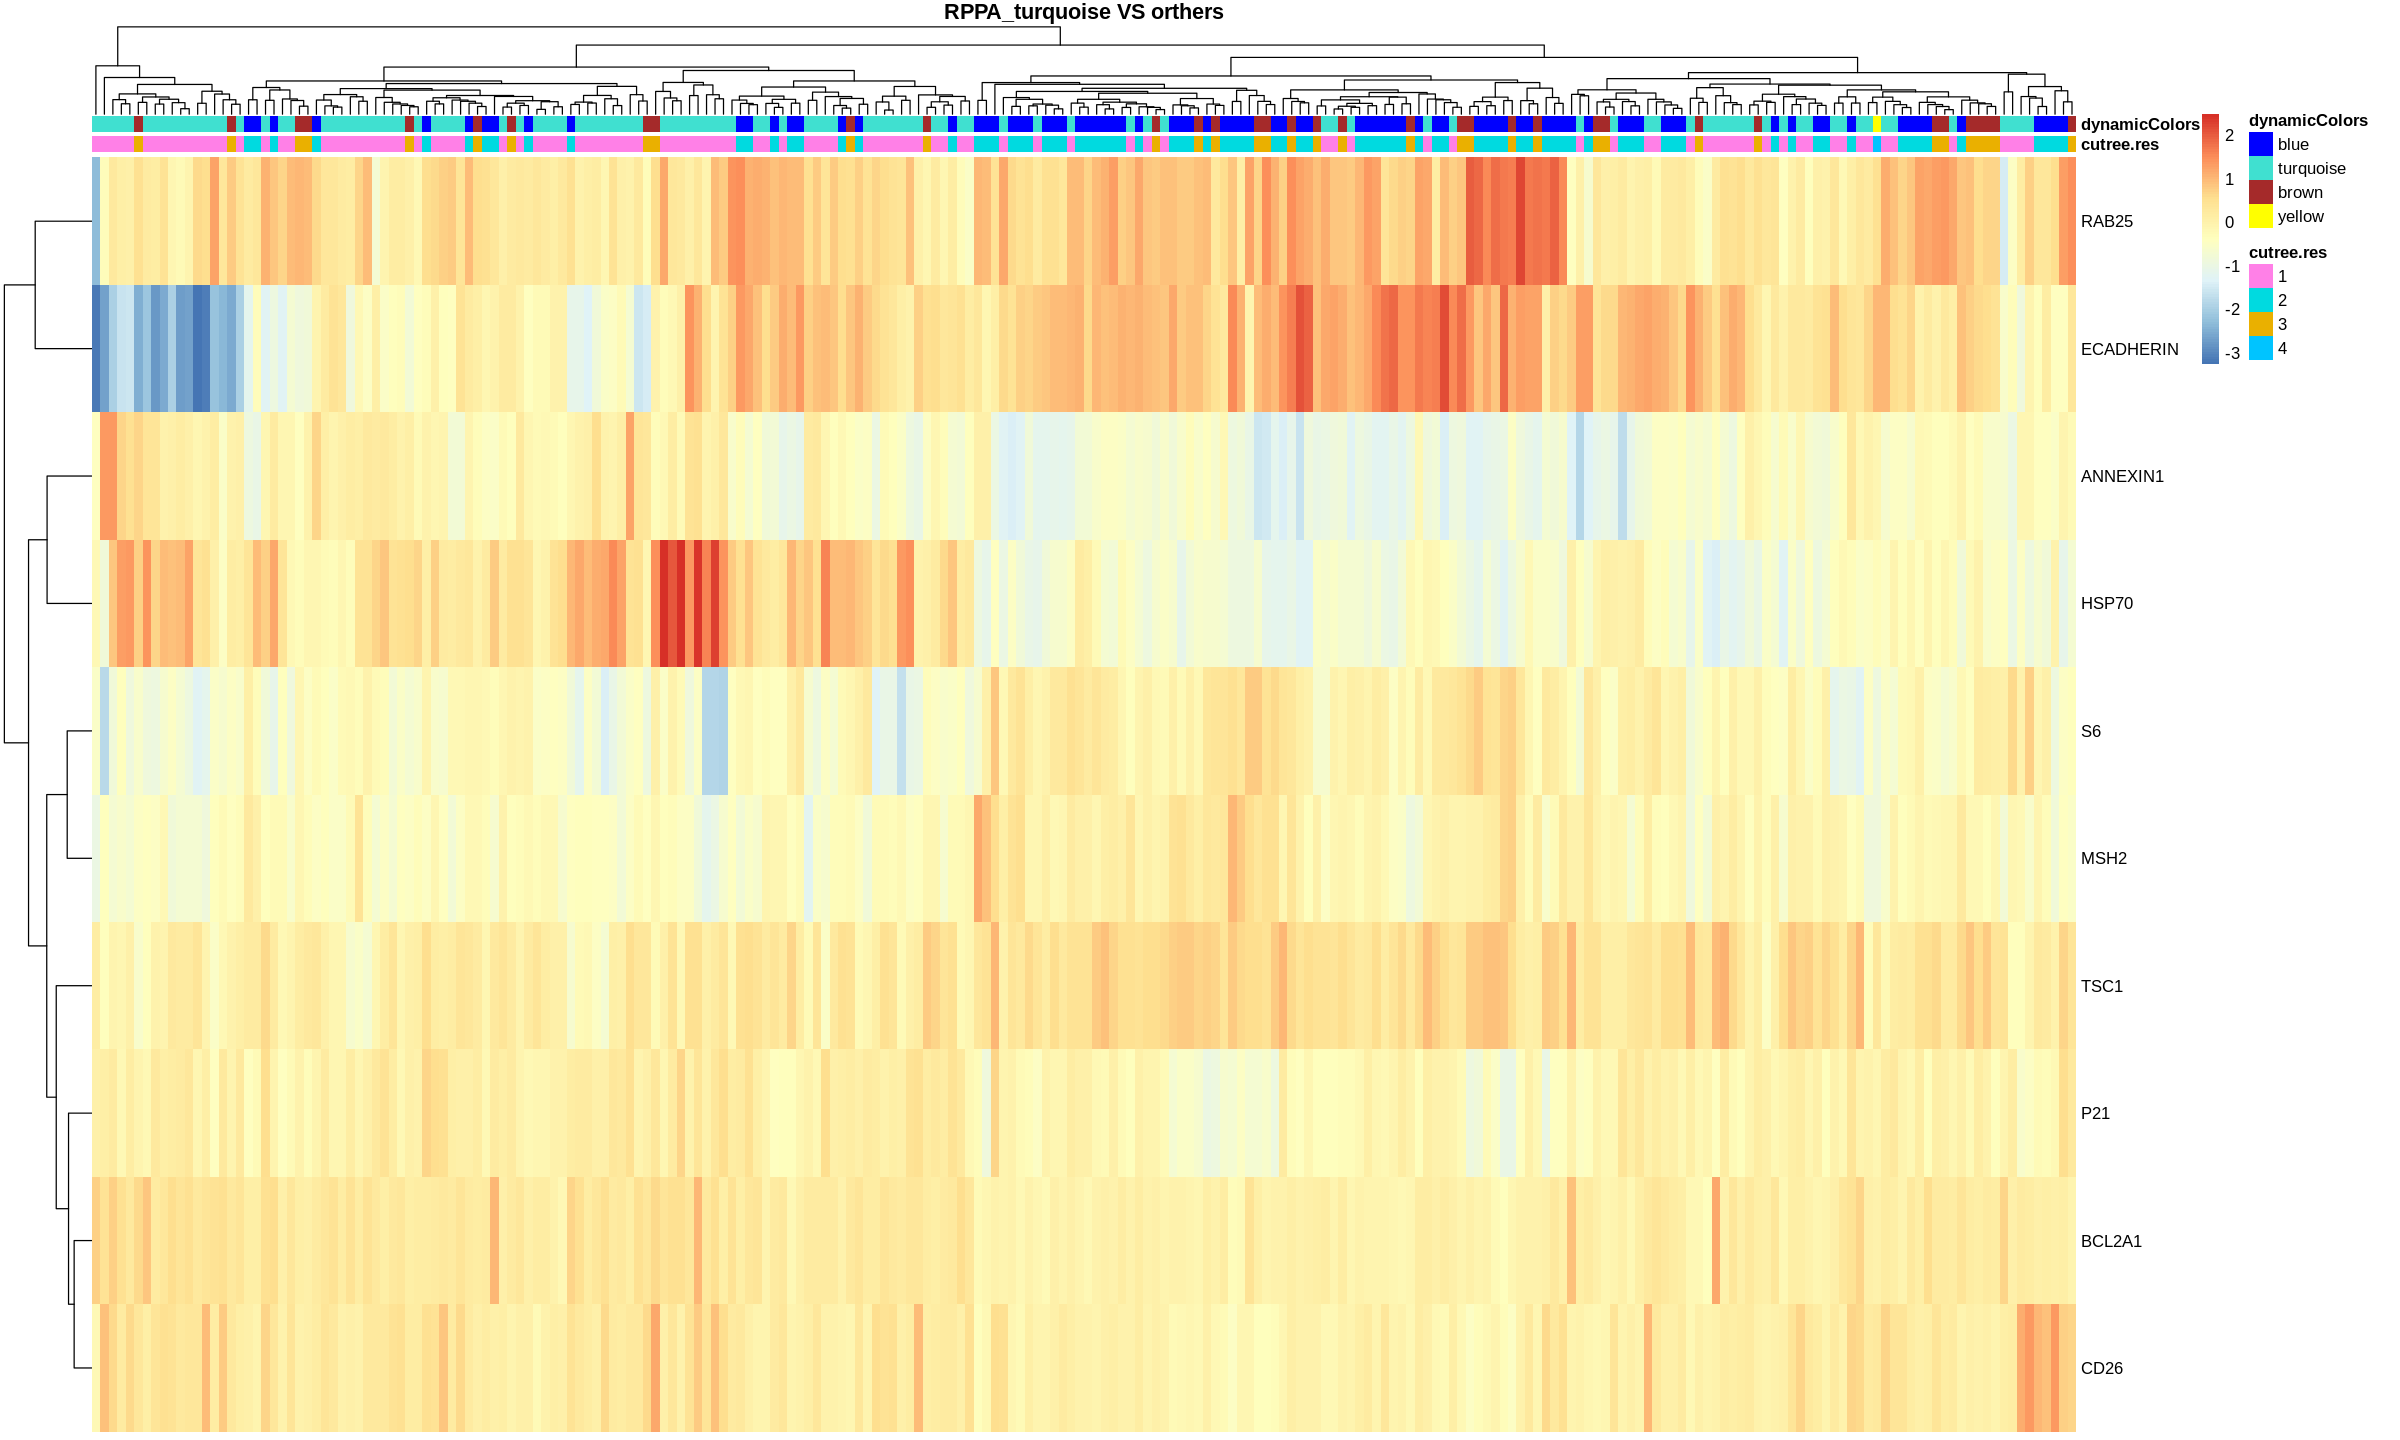

In [6]:
## 6) Heatmap ploting
ann_colors = list(dynamicColors = c(blue = "blue",turquoise = "turquoise", 
                                    brown = "brown", yellow = "yellow"))
options(repr.plot.width=20, repr.plot.height=12)
pheatmap::pheatmap(COAD.RPPA.set[rownames(RPPA.blue),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.RPPA.set[rownames(RPPA.brown),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.RPPA.set[rownames(RPPA.turquoise),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_turquoise VS orthers",annotation_colors = ann_colors)


Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-2.0000  0.2830  0.6336  0.5804  1.0265  2.0000 

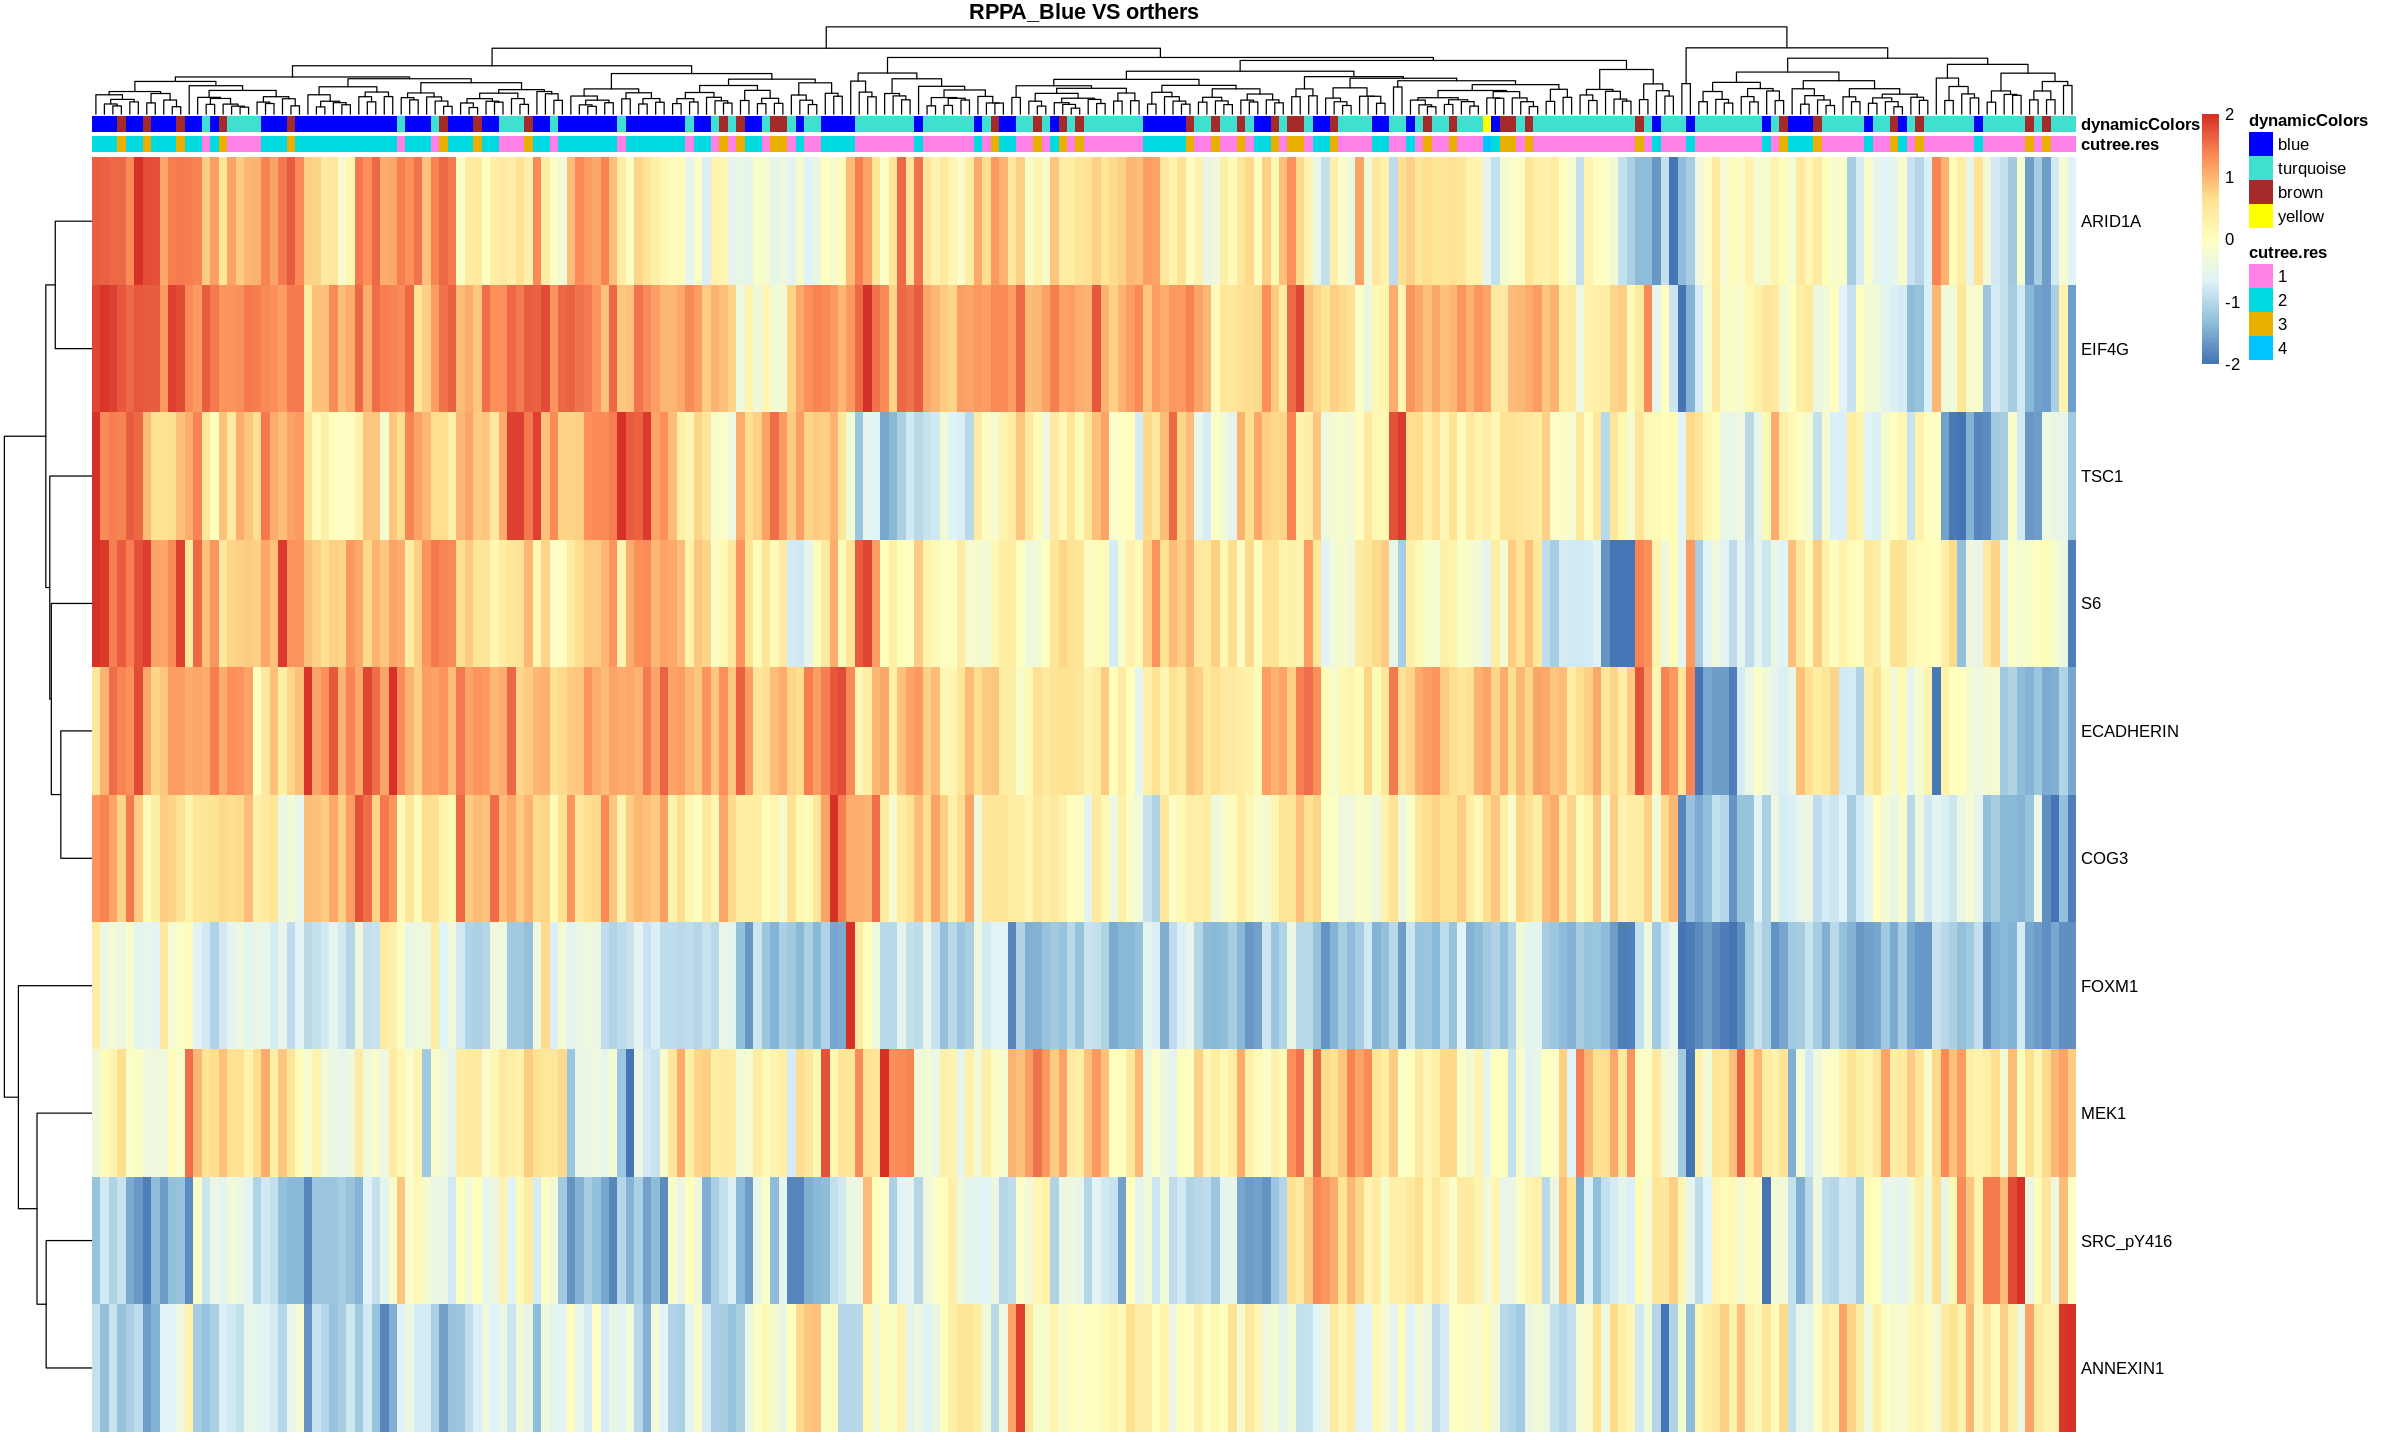

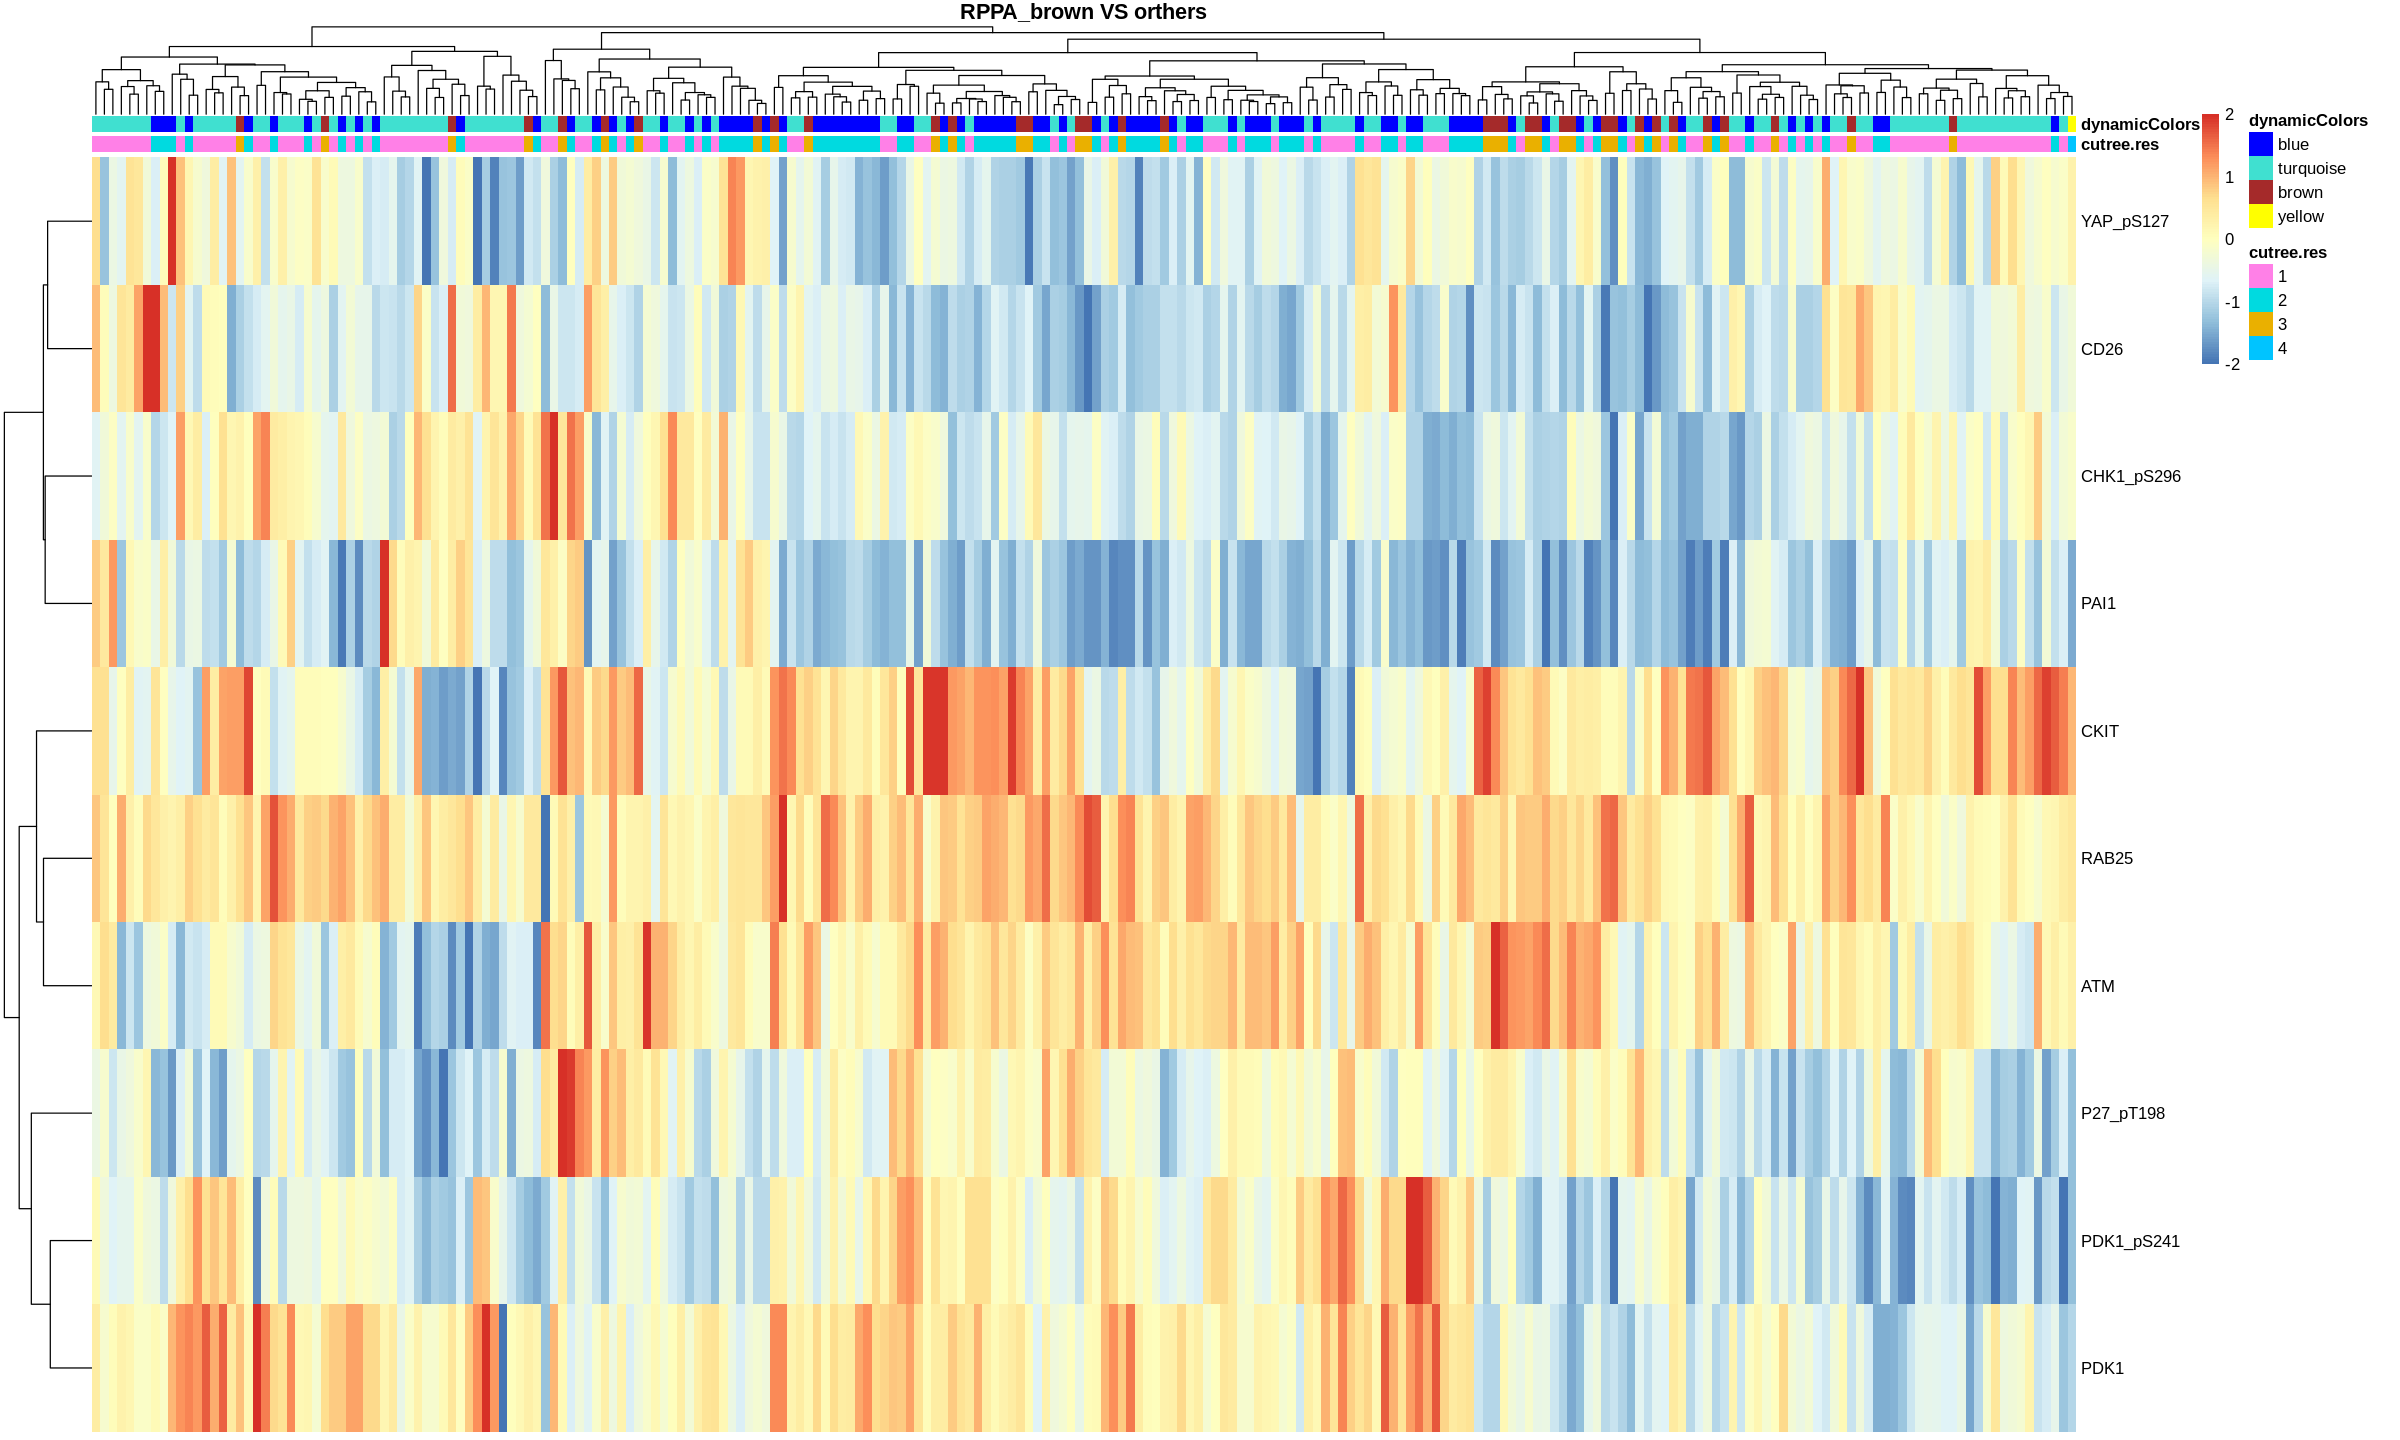

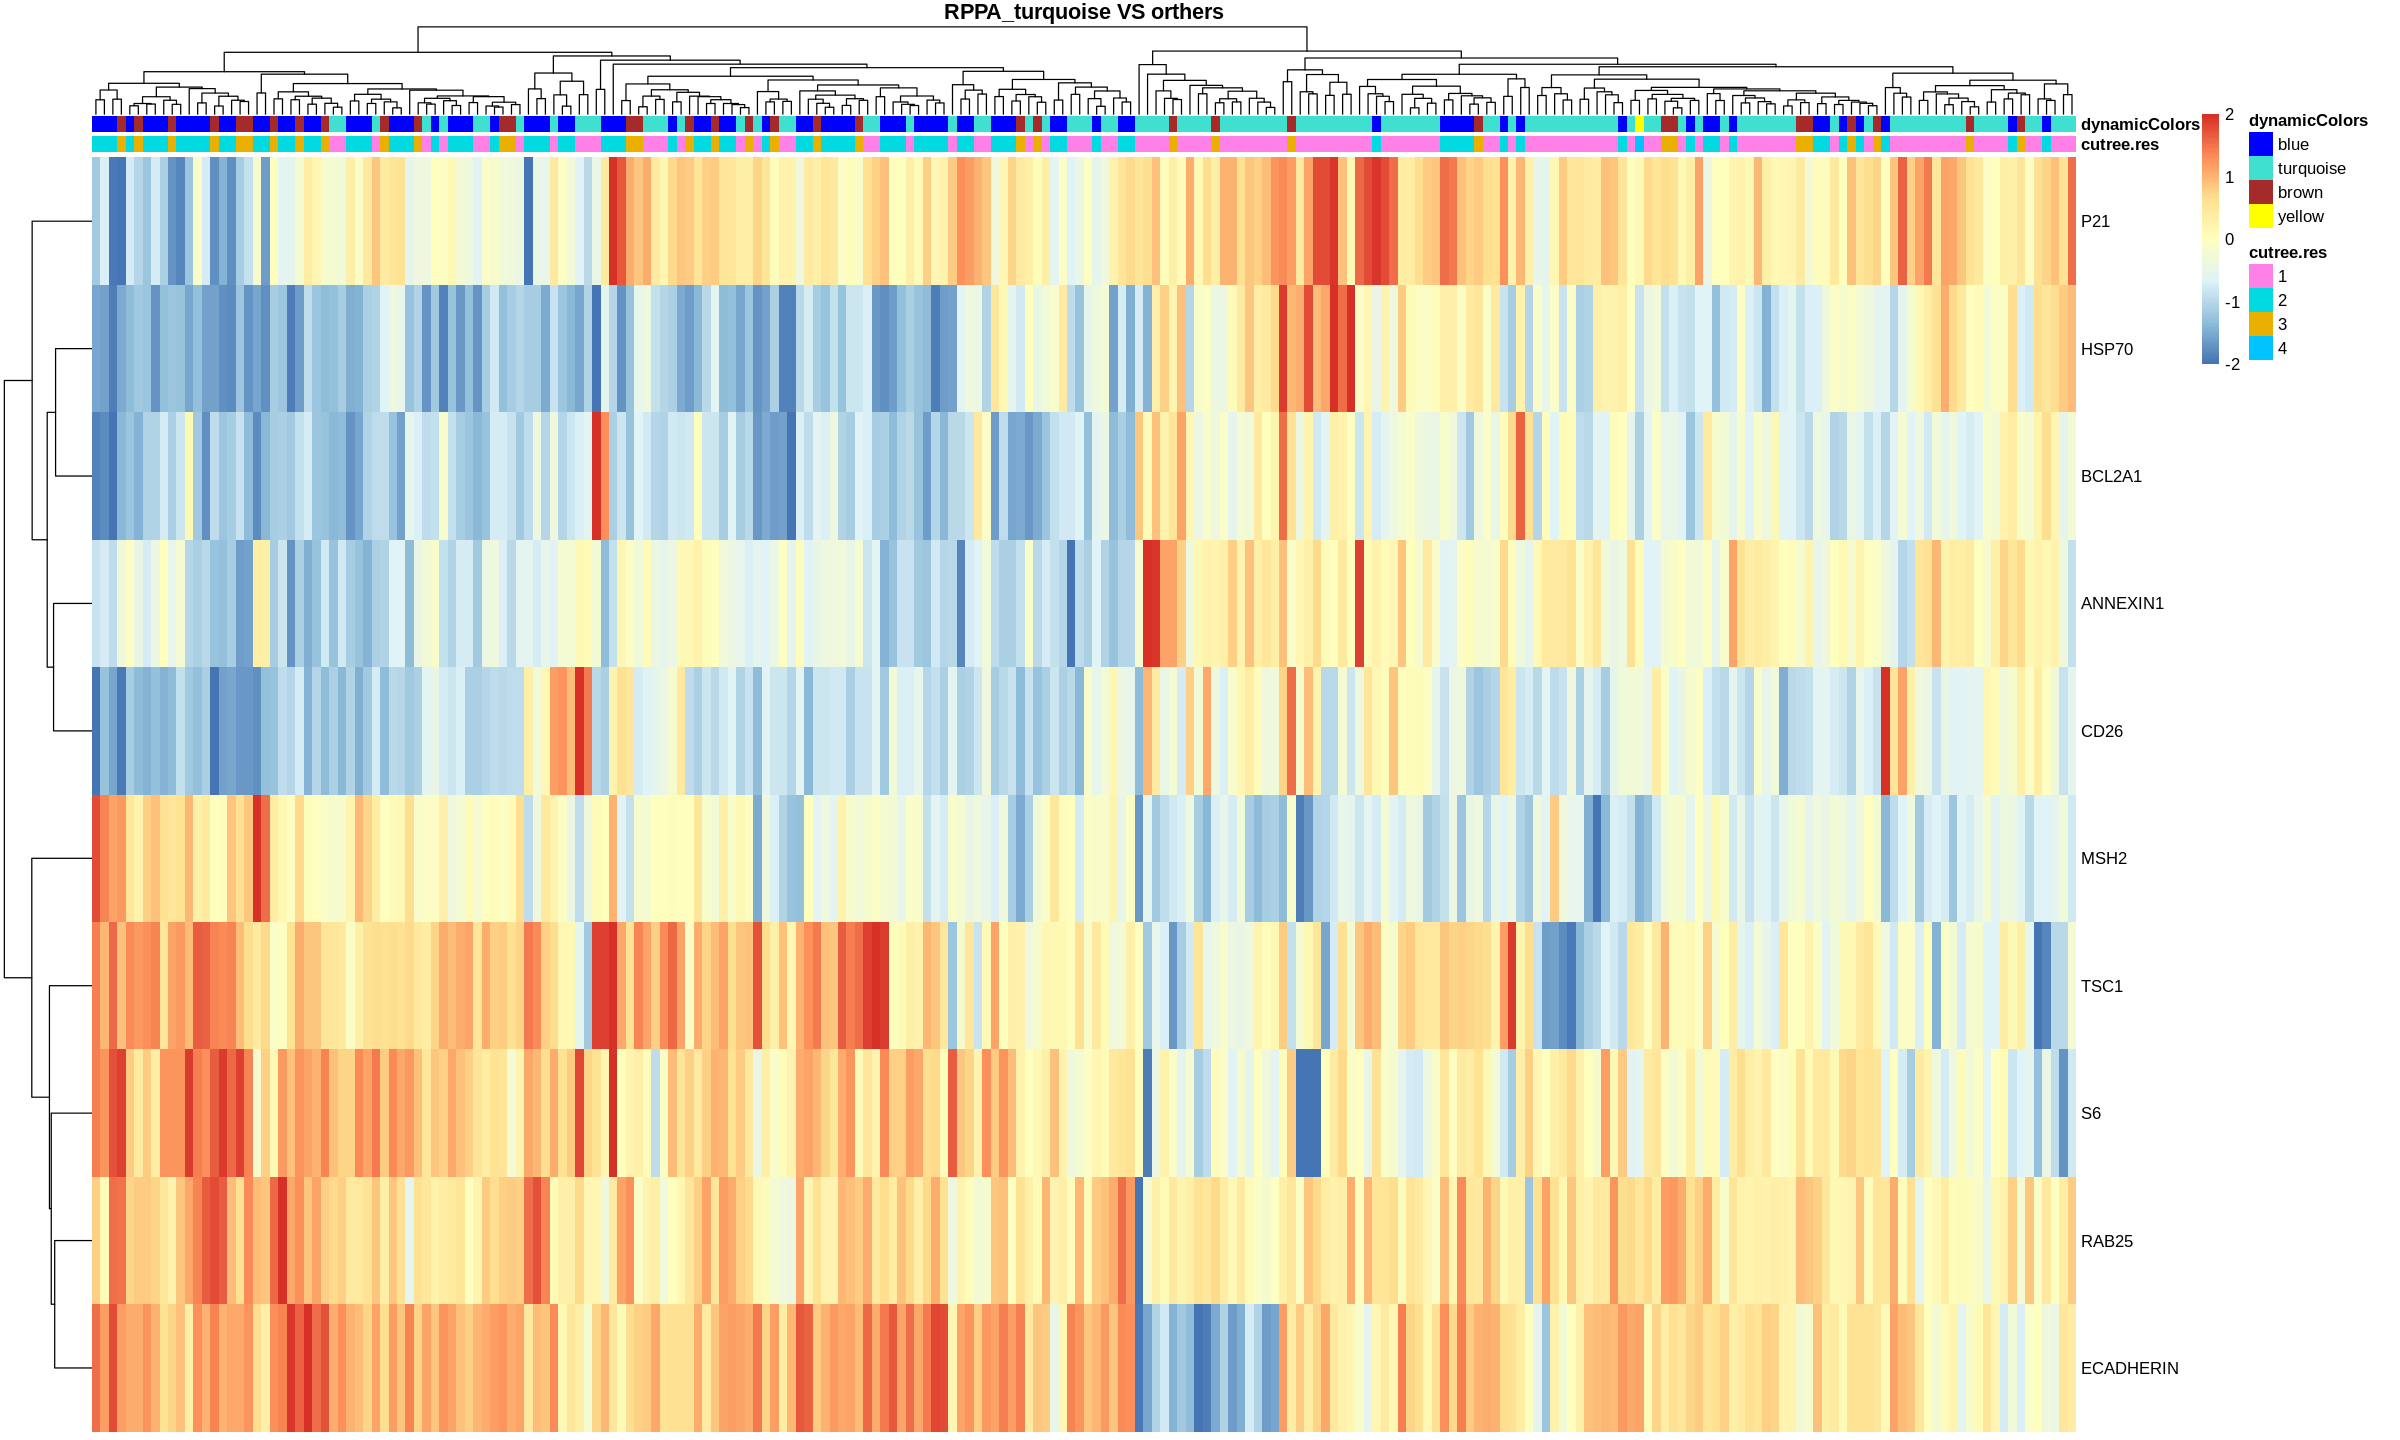

In [7]:
### 7) Ploting rescaled RPPAlation data
ann_colors = list(dynamicColors = c(blue = "blue",turquoise = "turquoise", 
                                    brown = "brown", yellow = "yellow"))
library(scales)
COAD.RPPA.scaled <- t(apply(COAD.RPPA.set, 1, rescale, to=c(-2,2)))
summary(COAD.RPPA.scaled[5,])
pheatmap::pheatmap(COAD.RPPA.scaled[rownames(RPPA.blue),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_Blue VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.RPPA.scaled[rownames(RPPA.brown),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_brown VS orthers",annotation_colors = ann_colors)
pheatmap::pheatmap(COAD.RPPA.scaled[rownames(RPPA.turquoise),],annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_turquoise VS orthers",annotation_colors = ann_colors)



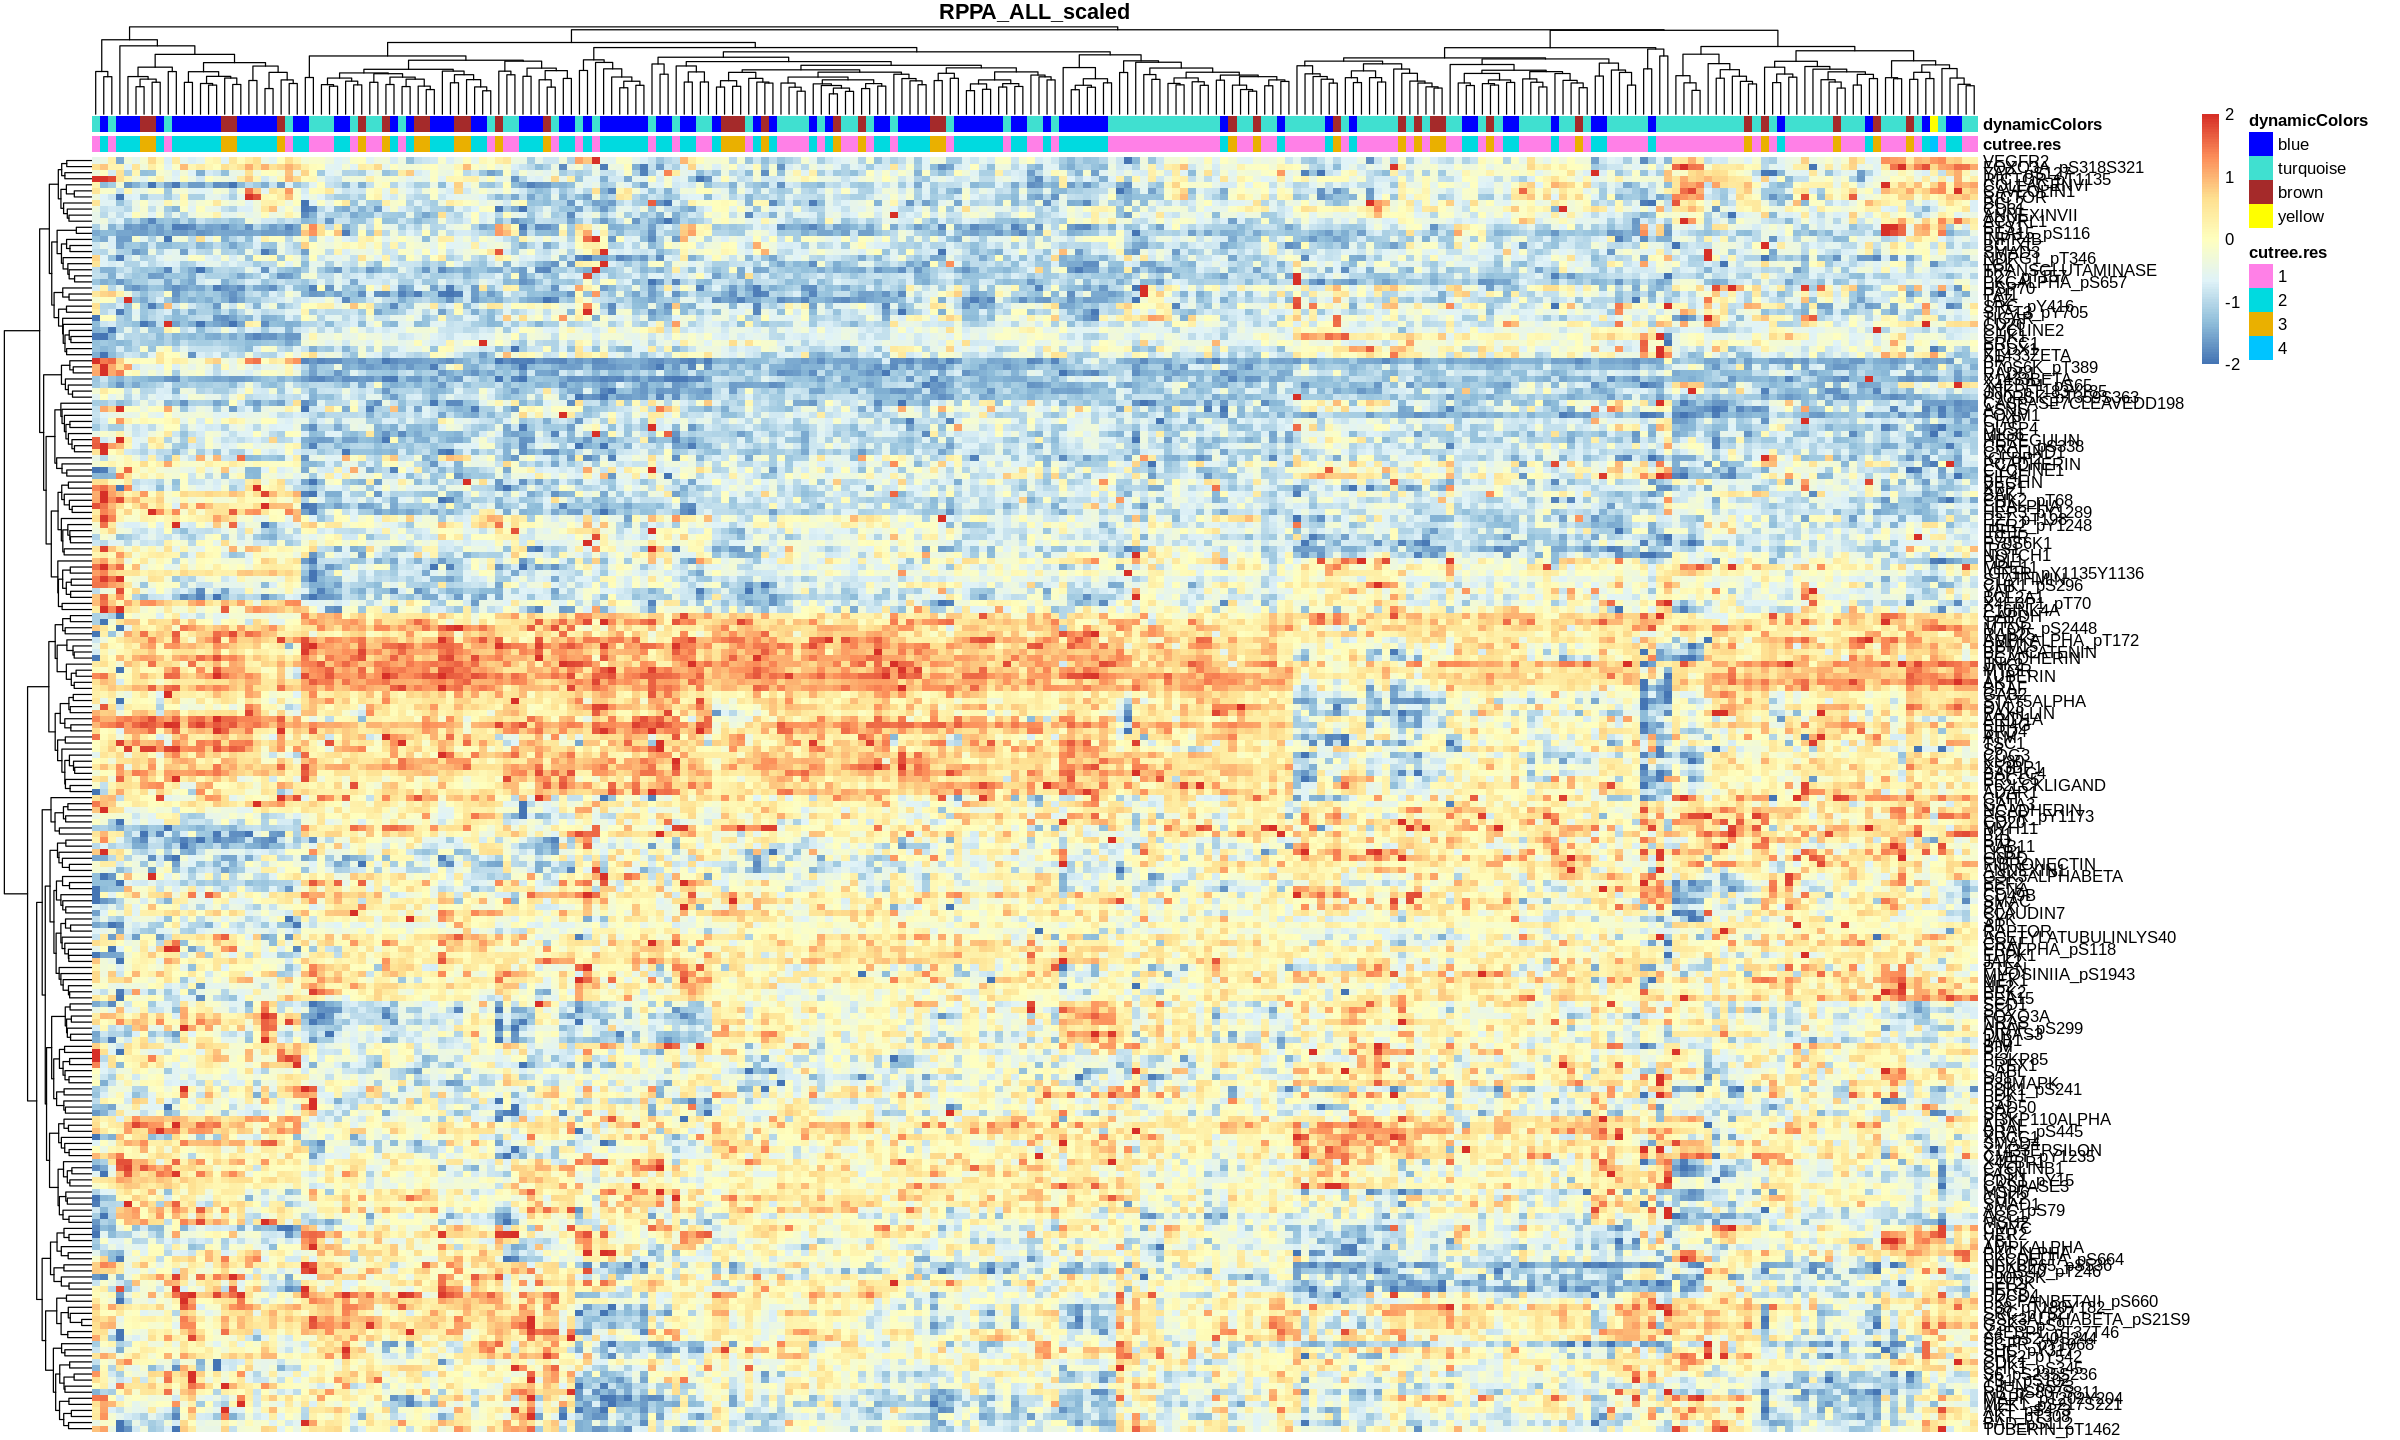

In [8]:
# remove NA rows
COAD.RPPA.scaled.full <- COAD.RPPA.scaled[complete.cases(COAD.RPPA.scaled), ]

pheatmap::pheatmap(COAD.RPPA.scaled.full,annotation_col = pData(COAD.RPPA.set)[,1:2],show_colnames = F,
                   main = "RPPA_ALL_scaled",annotation_colors = ann_colors)
